<a href="https://colab.research.google.com/github/MasaAsami/LTsandox/blob/main/notebooks/DL%E3%81%AE%E3%81%9F%E3%82%81%E3%81%AE%E6%9C%80%E9%81%A9%E5%8C%96%E5%85%A5%E9%96%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q japanize_matplotlib

     |████████████████████████████████| 4.1 MB 13.8 MB/s 


In [3]:
#@title Pythonモジュールをimport { display-mode: "form" }

import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy as sp
import sympy as sym

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go
import plotly.express as px
import japanize_matplotlib

plt.style.use(
    "ggplot"
) 

import seaborn as sns

%matplotlib inline

## 1. 確率勾配法の基礎の基礎
 　機械学習における最適化は、おもに大規模データでの学習に苦しめられる。そこで活躍すのが**確率的最適化(stochastic optimization)**です。
 <br>　学習に必要な最適化に汎用の最適化ソルバーをそのまま当てはめると、１回の更新に、最低でもサンプルサイズ×次元のオーダーがかかってしまうので、データが巨大なときは１回の更新の終了まで長い時間待たなければなりません。
 <br>　このような問題を解決するために、データを適切に分割し、ランダムにその小さな部分問題を解いてゆき、結果的にデータ全体を用いた最適化を解いてしまおうというアイデアが**確率的最適化**です。
 <br>　本日はその中で最も基本的な**SGD(stochastic gradient descent:確率勾配法)**に触れます。

### (1)普通の勾配法
 　まずは、最もオーソドックスな勾配法について、復習します。
 <br>　ロジスティック回帰の説明は割愛します。ググってください。ちなみに、下はリンク関数のシグモイド関数ですね。

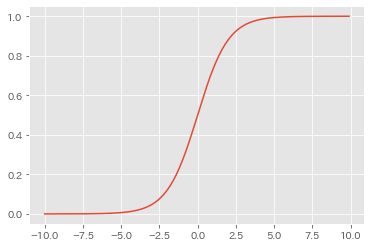

In [4]:
def sigmoid(x):
  return 1.0 / (1.0 + np.exp(-x))

a = np.arange(-10, 10, 0.1)

plt.plot(a, sigmoid(a))
plt.show()

　 さて、ロジスティック回帰の尤度$L$を定義します。（ラベルをc(0 or 1)としています。）<br>
 <br>
  $$L({\bf w},{\bf b}) = \prod_{n=1}^{N} p({\bf y}|{\bf x}) = \prod_{n=1}^N s({\bf x}_n)^{c_n}(1-s({\bf x}_n))^{1-c_n}$$
  <br>
 $s({\bf x})=\sigma(f({\bf x}))$で、$\sigma(.)$はシグモイド関数です。また、$f({\bf x})$は、線形予測子$f({\bf x})={\bf w}^{\mathrm{T}}{\bf x}$です。尤度$L$の対数をとり、符号を反転させると、以下のとおりです。<br>
 <br>
 $$-lnL({\bf w}) =- \sum_{n=1}^{N}ln \left\{
p({\bf y}|{\bf x}) \right\}= -\sum_{n=1}^N ln\left\{
 s({\bf x}_n)^{c_n}(1-s({\bf x}_n)^{1-c_n}\right\}=-\sum_{n=1}^{N}\left\{c_{n}ln{s(\bf x}_n)+(1-c_n)ln(1-s({\bf x}_n)) \right\}\tag{1.1}$$
 <br><br>
 　これを最小化問題としてと解けばよい。ちなみに、これは誤差関数の定義でもあります。これを**交差エントロピー誤差関数(cross-entropy error function)**$E({\bf w})$といいます。<br>
  $$E({\bf w})\equiv -lnL({\bf w})$$ 
  
 <br>　ちなみに、シグモイド関数$\sigma(x)$の導関数は以下のとおり。<br><br>
 $$\frac{d\sigma}{dx}=\frac{exp(x)}{(1+exp(x))^2}=\sigma(x)\frac{1+exp(x)-1}{1+exp(x)}=\sigma(x)(1-\sigma(x))\tag{1.2}$$
 <br>

  求めるべき**w**について、偏微分してみる。


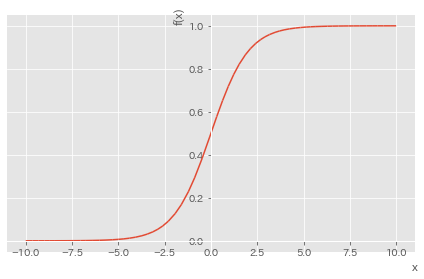

In [6]:
x, y, dy = sym.symbols('x y dy')
y = 1 / (1 + sym.exp(-x))

sym.plotting.plot(y, (x, -10, 10))

In [7]:
dy = sym.diff(y, x, 1)
dy

exp(-x)/(1 + exp(-x))**2

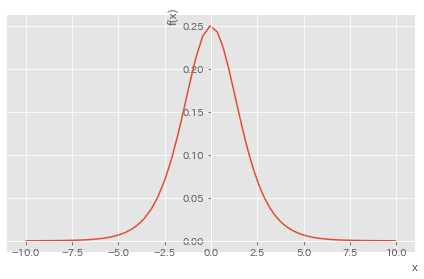

In [8]:
sym.plotting.plot(dy, (x, -10, 10))


**wについての偏導関数**<br>

　式（1.2）に注意して、解くと以下のとおり。<br>
 $$
 \frac{\partial E}{\partial {\bf w}} = -\sum_{n=1}^N\left\{c_{n}\frac{\partial \sigma(f({\bf x}_{n}))}{\partial f({\bf x}_{n})}\frac{\partial f({\bf x}_{n})}{\partial {\bf w}_{n}}+(1-c_{n})\frac{\partial ln (1-\sigma(f({\bf x}_{n})))}{\partial f(x_{n})} \frac{\partial f(x_{n})}{\partial w}\right\}$$
 $$\frac{\partial E}{\partial {\bf w}} = -\sum_{n=1}^{N} {\bf x}_{n}(c_{n}-s({\bf x}_{n})) \tag{1.3}
 $$
 <br>
  <br>
  　式（1.3）＝０とおいても、シグモイド関数$\sigma({\bf x})$を含んでおり、解析的に$w$を求めることはできない。<br>
　こういった際、勾配法等を用いる（ここでは最もシンプルな最急降下法steepest decent method）。<br>
　荒っぽく説明すれば、勾配ベクトル$\nabla E$は、目的関数$L$の値が最も大きく増加する方向なので、勾配ベクトルと逆の方向$-\nabla E$は、${\bf w}$において最も減少する方向である。なお、勾配ベクトル$\nabla E$は$\nabla E \equiv \frac{\partial E}{\partial {\bf w}}=\left[\frac{\partial E}{\partial w_{1}}\cdots \frac{\partial E}{\partial w_{M}}\right]^{\mathrm{T}}$です。(Mはパラメータwの個数です。)<br><br>
 適当な初期値$w^(1)$を設定し、下記の更新式(1.4)を繰り返すと（局所的な）極小解にたどりつきます。
 <br><br>
 $${\bf w}^{(t+1)}\longleftarrow {\bf w}^{(t)}-\epsilon\nabla E \tag{1.4}$$
 <br>
 　$\epsilon$は**学習係数(learning rate)**と呼ばれ、更新量の大きさを与える定数となります。この学習係数$\epsilon$の設定方法は色々ありますが、後ほど。<br>
  上記のような非線形関数の最小化手法は、上記のようなシンプルな解法の他に、ヘッシアンを用意するニュートン法や、その派生の準ニュートン法等、様々な解放が用意されています。今回のシンプルな手法は一次収束（収束が遅いこと）や$\epsilon$の値に学習が左右されるため、普通であればあまり使用しません。<br>
  （例えば、今回のようなロジスティック回帰の場合、ニュートン・ラフソン法(Newton-Raphson method)で解けばよい。）<br>
  ただし、Deep Learningの場合、目的関数の二次微分の計算が難しく、一次微分の計算がやっとというケースがほとんどです。なので、このシンプルな勾配法が好まれます。


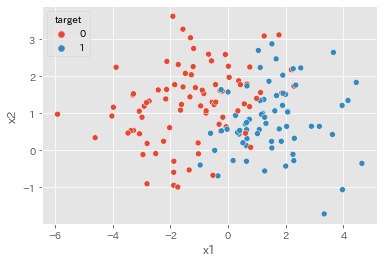

In [53]:
# @title sample data { display-mode: "form" }
TRUE_W1 = 2.
TRUE_W2 = -1.

np.random.seed(seed=2022)
x1 = np.random.normal(loc=0.0, scale=2.0, size=150)
x2 = np.random.normal(loc=1.0, scale=1.0, size=150)

z = TRUE_W1*x1 + TRUE_W2*x2
true_p = sigmoid(z)

df = pd.DataFrame(
    {
        "x1" : x1,
        "x2" : x2,
        "target" : np.random.binomial(1, true_p)
    }
)
X = df[["x1", "x2"]]
y = df["target"]

sns.scatterplot(
    x="x1",
    y="x2",
    hue="target", 
    data=df
)

In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(fit_intercept=False) 
lr.fit(X, y) 
print("傾き", lr.coef_)
print("切片", lr.intercept_)

傾き [[ 1.66940435 -0.86175804]]
切片 [0.]


sklearn における予測結果 
$$
P(C|X)=\frac{1}{1+exp(-z)}, \qquad　z = 1.66940435 * x_1 + -0.86175804*x_2
$$


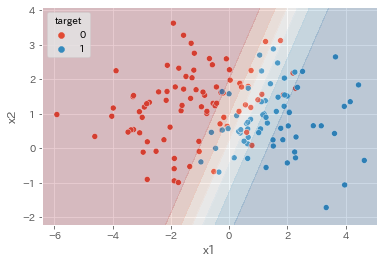

In [11]:
#@title 分離断面を可視化 { display-mode: "form" }
def separate_plot(df, X, model ):

    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    sns.scatterplot(
        x="x1",
        y="x2",
        hue="target", 
        data=df
    )

    x_min, x_max = X["x1"].min() - .5, X["x1"].max() + .5
    y_min, y_max = X["x2"].min() - .5, X["x2"].max() + .5
    
    h = 0.1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
        )
    
    Z = model.predict_proba(
        np.c_[xx.ravel(), yy.ravel()]
        )[:,1]
    Z = Z.reshape(xx.shape)

    cm = plt.cm.RdBu
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.2)
    plt.show()

separate_plot(df, X, lr)

In [12]:
def _cross_entropy_loss(yHat, y):
    if y == 1:
      return -np.log(yHat)
    else:
      return -np.log(1 - yHat)

def cross_entropy_loss(df, X, model):
   result_df = df.copy()
   result_df["pred"] =  model.predict_proba(X)[:,1]
   result_df["loss"] = result_df.apply(lambda x : _cross_entropy_loss(x["pred"], x["target"]), axis=1)
   return result_df["loss"].sum()


In [13]:
cross_entropy_loss(df, X, lr)

45.92218828397826

In [14]:
h = 0.5
w1, w2 = np.meshgrid(
    np.arange(-3, 3 + h, h),
    np.arange(-3, 3 + h, h)
    )

candidate_w = pd.DataFrame(np.c_[w1.ravel(), w2.ravel()], columns=["w1", "w2"])

candidate_w["w0"] = lr.intercept_[0]
candidate_w

,w1,w2,w0
0,-3.0,-3.0,0.0
1,-2.5,-3.0,0.0
2,-2.0,-3.0,0.0
3,-1.5,-3.0,0.0
4,-1.0,-3.0,0.0
...,...,...,...
164,1.0,3.0,0.0
165,1.5,3.0,0.0
166,2.0,3.0,0.0
167,2.5,3.0,0.0


In [15]:
def w_based_error(w1, w2, w0, X, y):
    _z = X.dot([w1, w2]) + w0
    _result = pd.DataFrame(
        {
            "pred" : sigmoid(_z),
            "target" : y
        }
    )
    return _result.apply(lambda x : _cross_entropy_loss(x["pred"], x["target"]), axis=1).sum()

In [16]:
w_based_error(-2.77743512, -2.38548149, 17.547105, X, y)

1512.4701015125265

In [17]:
candidate_w["loss"] = candidate_w.apply(lambda x :  w_based_error(x["w1"], x["w2"], x["w0"], X, y), axis=1).replace([np.inf, -np.inf], np.nan)

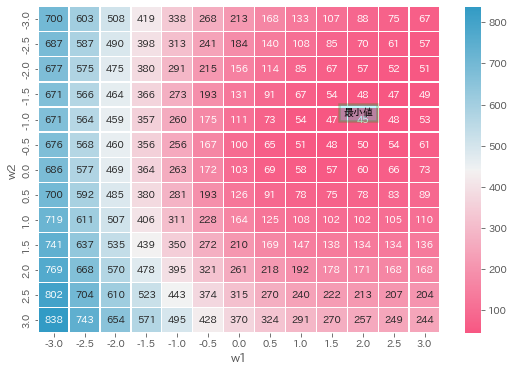

In [69]:
_pivot = candidate_w.pivot("w1", "w2", "loss")

f, ax = plt.subplots(figsize=(9, 6))
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

sns.heatmap(_pivot.T.astype(int),  ax=ax, cmap=cmap, annot=True, fmt="d", linewidth=0.3)

original_length = 3-(-3)
origibal_w1 = (3 + TRUE_W1) / original_length
original_w2 = (3 + TRUE_W2) / original_length

bbox_dict = dict(facecolor="#00ffff",
                 edgecolor="#009900",
                 alpha=0.25,
                 linewidth=2.5,
                 linestyle="-")

ax.text(
    origibal_w1 * max(ax.get_xlim()) ,
    original_w2 * max(ax.get_ylim()),
    '最小値',
    #c='tab:red',
    ha='right',
    bbox = bbox_dict 
    )
plt.show()

In [59]:
ax.get_ylim()

(13.0, 0.0)

  <br><br>
### (2) 確率勾配法 <br>

 上記のような手法（データをまとめて最適化する方法）を**バッチ学習**と呼びます。これに対して、サンプルの一部、もしくはサンプル１つだけを使ってパラメータの更新を行う方法があります。**確率的最適化**（あるいは「オンライン最適化」）といいます。ここでは、**確率的勾配法(SGD: stochastic gradient decent)**を紹介します。<br>
 
- 確率勾配法(SGD)<br>
 この方法は、$w$の更新は１つのサンプル$n$について計算される誤差関数$E_{n}({\bf w})$の勾配$\nabla E_{n}$を計算し、下記の更新式のとおり、$w$を更新します。<br><br>
$${\bf w}^{(t+1)}\longleftarrow {\bf w}^{(t)}-\epsilon\nabla E_{n}^{(t)}  \tag{1.5}$$
<br><br>
 一見、更新式(1.4)と似ていますが、勾配$\nabla E_{n}$に注意してください。次の、${\bf w}^{(t+1)}$を更新するステップでは、別のサンプル$n'$を取り出し、$\nabla E_{n'}$を計算し、更新します。<br><br>
【メリット】<br>
    - 訓練データが冗長なとき、計算のコスパがよい。<br>水増し程度の情報価値しかないデータの場合、いちいち計算するのは計算の無駄）<br>
    - (極端な)局所的な極小解にハマるリスクが少ない。<br>(目的関数が$w$の更新ごとに異なるため、局所極小解にハマるリスクがバッチ学習より少ない。)
　　<br>
<br>
- ミニバッチ確率勾配法(Minibatch SGD) <br>
 並列計算に便利なミニバッチ処理にも触れておきます。少数のサンプルの集合をひとまとめにして、その単位で重みを更新する方法もあります。このひとまとめのサンプル集合を**ミニバッチ(minibatch)**と呼びます。<br>
 まず１つのミニバッチを$D_t$と書くとします。この$D_t$を服舞う全サンプルに対する誤差は下記のとおりです。<br><br>
 $$E_{t}({\bf w})=\frac{1}{|D_{t}|}\sum_{n \in D_{t}}E_{n}^{(t)} ({\bf w}) \tag{1.6}$$
<br><br>
 この勾配の方向にパラーメータを更新します。なお、$|D_{t}|$は、ミニバッチ内のサンプル数です。